# Trying to Learn Neural Network with Tensorflow

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix

import cv2

Données 

In [3]:
%%time
from glob import glob
import os

imPath = "Paint_image/logo_drew/"
ls_path = glob(os.path.join(imPath, '*' ))

Wall time: 13 ms


ls_path

Ne pas oublier le One-Hot Encoding 

In [4]:
name_to_label ={'tinder':[1,0],'messenger':[0,1]} #Pour labeliser facilement

data_base={'data': [], 'label' : [],'nom_label' :[],'image':[]}
for file in ls_path:                        #On parcours tous les fichiers                
    im = cv2.imread(file,0)                 #On charge l'image
    im=255-im                               #On inverse le contrast 
    #im = cv2.resize(im, (8, 8))             #On met au bon format de pixels
    name= file.split('\\')[1].split('_')[0] #On extrait le type
    data_base['data']+=[np.ndarray.flatten(im)]
    data_base['label']+=[name_to_label[name]]
    data_base['nom_label']+=[name]
    data_base['image']+=[im]
data_base['data']=np.array(data_base['data'])
data_base['label']=np.array(data_base['label'])
data_base['nom_label']=np.array(data_base['nom_label'])
data_base['image']=np.array(data_base['image'])
    

data_base

In [5]:
data_base['image'][1].size

4096

In [6]:
# Tuple with height and width of images used to reshape arrays.
img_shape = data_base['image'][1].shape

# The images are stored in one-dimensional arrays of this length.
img_size_flat = data_base['image'][1].size

# Number of classes, one class for each of 10 digits.
num_classes = 2

In [7]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3,  figsize=(10,5))
    fig.subplots_adjust(hspace=0.3, wspace=0.1)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0},Pred: {1}".format(cls_true[i], cls_pred[i])

        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
        
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

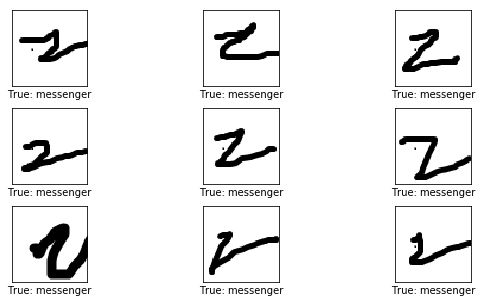

In [8]:
# Get the first images from the test-set.
images = data_base['image'][5:14]

# Get the true classes for those images.
cls_true = data_base['nom_label'][5:14]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

In [9]:
x = tf.placeholder(tf.float32, [None, img_size_flat])

In [10]:
y_true = tf.placeholder(tf.float32, [None, num_classes])

In [11]:
y_true_cls = tf.placeholder(tf.int64, [None])

In [12]:
weights = tf.Variable(tf.zeros([img_size_flat, num_classes]))

In [13]:
biases = tf.Variable(tf.zeros([num_classes]))

In [14]:
logits = tf.matmul(x, weights) + biases

In [15]:
y_pred = tf.nn.softmax(logits)

In [16]:
y_pred_cls = tf.argmax(y_pred, axis=1)

In [17]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits,
                                                           labels=y_true)

In [18]:
cost = tf.reduce_mean(cross_entropy)

In [19]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.5).minimize(cost)

In [20]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

In [21]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# RUN

In [22]:
session = tf.Session()

In [23]:
session.run(tf.global_variables_initializer())

In [24]:
batch_size = 100

In [25]:
X= data_base['data']
Y= data_base['label']

In [26]:
from sklearn.cross_validation import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(X, Y, test_size=0.1,
                                                random_state=0)

C:\Users\Delanoue\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [27]:
def optimize(num_iterations):
    for i in range(num_iterations):
        # Get a batch of training examples.
        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images.
        
        x_batch = Xtrain
        y_true_batch = ytrain
        
        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        # Note that the placeholder for y_true_cls is not set
        # because it is not used during training.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}

        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        session.run(optimizer, feed_dict=feed_dict_train)

In [28]:
j={'[1 0]':0,'[0 1]':1}

In [29]:
feed_dict_test = {x: Xtest,
                  y_true: ytest,
                  y_true_cls: [j[str(a)] for a in ytest]}

In [30]:
def print_accuracy():
    # Use TensorFlow to compute the accuracy.
    acc = session.run(accuracy, feed_dict=feed_dict_test)
    
    # Print the accuracy.
    print("Accuracy on test-set: {0:.1%}".format(acc))

In [31]:
def print_confusion_matrix():
    # Get the true classifications for the test-set.
    cls_true = feed_dict_test['y_true_cls']
    
    # Get the predicted classifications for the test-set.
    cls_pred = session.run(y_pred_cls, feed_dict=feed_dict_test)

    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # Print the confusion matrix as text.
    print(cm)

    # Plot the confusion matrix as an image.
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

    # Make various adjustments to the plot.
    plt.tight_layout()
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [32]:
label_to_name ={0:'tinder',1:'messenger'}

In [33]:
def plot_example_errors():
    # Use TensorFlow to get a list of boolean values
    # whether each test-image has been correctly classified,
    # and a list for the predicted class of each image.
    correct, cls_pred = session.run([correct_prediction, y_pred_cls],
                                    feed_dict=feed_dict_test)
    
    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    
    images = np.tile(Xtest[incorrect],(9,1))
    
    # Get the predicted classes for those images.
    cls_pred = np.tile(cls_pred[incorrect],9)
    
    # Get the true classes for those images.
    cls_true = np.tile(np.array(feed_dict_test[y_true_cls])[incorrect],9)
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=[label_to_name[a] for a in cls_true[0:9]],
                cls_pred=[label_to_name[a] for a in cls_pred[0:9]])

In [34]:
def plot_weights():
    # Get the values for the weights from the TensorFlow variable.
    w = session.run(weights)
    
    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(w)
    w_max = np.max(w)

    # Create figure with 3x4 sub-plots,
    # where the last 2 sub-plots are unused.
    fig, axes = plt.subplots(3, 4)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Only use the weights for the first 10 sub-plots.
        if i<10:
            # Get the weights for the i'th digit and reshape it.
            # Note that w.shape == (img_size_flat, 10)
            image = w[:, i].reshape(img_shape)

            # Set the label for the sub-plot.
            ax.set_xlabel("Weights: {0}".format(i))

            # Plot the image.
            ax.imshow(image, vmin=w_min, vmax=w_max, cmap='seismic')

        # Remove ticks from each sub-plot.
        ax.set_xticks([])
        ax.set_yticks([])
        
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [35]:
print_accuracy()

Accuracy on test-set: 70.0%


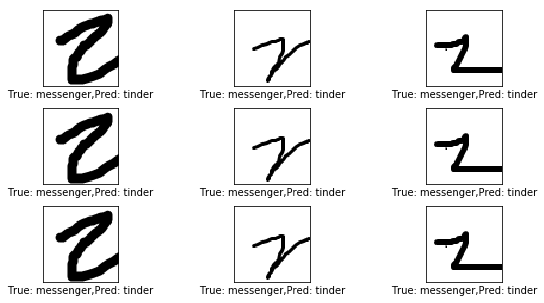

In [36]:
plot_example_errors()

In [37]:
optimize(num_iterations=2)

In [38]:
print_accuracy()

Accuracy on test-set: 30.0%


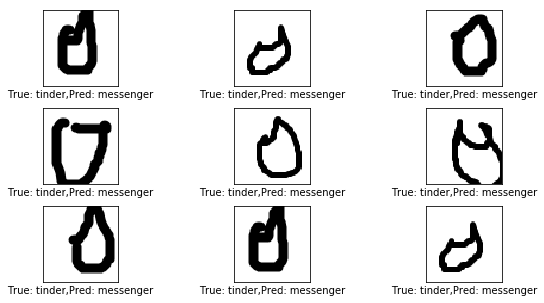

In [39]:
plot_example_errors()

In [40]:
optimize(num_iterations=10)

In [41]:
print_accuracy()

Accuracy on test-set: 80.0%


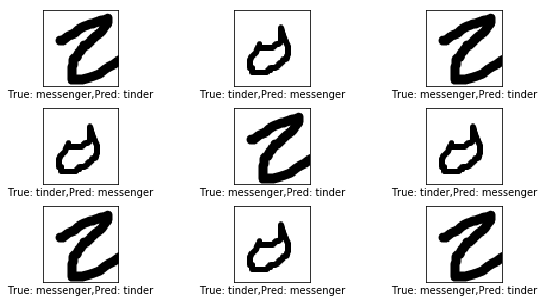

In [42]:
plot_example_errors()

In [43]:
optimize(num_iterations=1000)

In [44]:
print_accuracy()

Accuracy on test-set: 80.0%
